Dataset: https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import matplotlib
matplotlib.use('module://ipykernel.pylab.backend_inline')
import matplotlib.pyplot as plt
from sklearn import tree
import graphviz
plt.rcParams['figure.figsize'] = [15, 5]

Constatnt variables we will need later on

In [24]:
models = ['Random Forest', 'XGBoost', 'Gradient Boosting', 'SVM', 'Logistic Regression', 'Naive Bayes']
path = "/Users/mattmacrides/Personal-Projects/Employee Attrition - Machine Learning/"

Readiing in data

In [35]:
hr = pd.read_csv(path + 'HR.csv', sep=',', decimal='.')
# Dropping these columns because they all have the same values
hr = hr.drop(columns=['EmployeeCount', 'EmployeeNumber', 'StandardHours', 'Over18'])
hr.head(5)

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,1,2,2,Female,94,3,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,8,1,3,Male,61,2,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,2,2,4,Male,92,2,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,3,4,4,Female,56,3,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,2,1,1,Male,40,3,...,3,4,1,6,3,3,2,2,2,2


Converting cateogirical variables into dummy variables for modeling

In [36]:
# Store potentially useful string variables into dummy variables
hr['Attrition'] = hr['Attrition'].map({'Yes': 1, 'No': 0})
hr['BusinessTravel'] = hr['BusinessTravel'].map({'Travel_Frequently':2, 'Travel_Rarely':1, 'Non-Travel':0})
hr['Gender'] = hr['Gender'].map({'Male':1, 'Female':0})
hr['MaritalStatus'] = hr['MaritalStatus'].map({'Married':3, 'Divorced':2, 'Single':0})
hr['OverTime'] = hr['OverTime'].map({'Yes':1, 'No':0})

Department, EducationField, and JobRole will be a bit harder to map because they have a larger domain than the variables above. Let's start mapping them.

In [ ]:
'Department', 'EducationField', 'JobRole'

Overview of correlations. Looking to see any large correlations that are inherently expected.

In [38]:
hr.corr().style.background_gradient(cmap="Blues")

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Age,1.000000,-0.159205,-0.011807,0.010661,-0.001686,0.208034,0.010146,-0.036311,0.024287,0.029820,0.509604,-0.004892,0.117201,0.497855,0.028051,0.299635,0.028062,0.003634,0.001904,0.053535,0.037510,0.680381,-0.019621,-0.021490,0.311309,0.212901,0.216513,0.202089
Attrition,-0.159205,1.000000,0.127006,-0.056652,0.077924,-0.031373,-0.103369,0.029453,-0.006846,-0.130016,-0.169105,-0.103481,-0.160081,-0.159840,0.015170,0.043494,0.246118,-0.013478,0.002889,-0.045872,-0.137145,-0.171063,-0.059478,-0.063939,-0.134392,-0.160545,-0.033019,-0.156199
BusinessTravel,-0.011807,0.127006,1.000000,-0.015539,-0.009696,-0.008670,-0.011310,-0.044896,-0.004164,0.029300,-0.011696,0.008666,-0.015609,-0.013450,-0.008440,-0.030743,0.042752,-0.025727,0.001683,0.008926,-0.028257,0.007972,0.016357,0.004209,0.005212,-0.005336,0.005222,-0.000229
DailyRate,0.010661,-0.056652,-0.015539,1.000000,-0.004985,-0.016806,0.018355,-0.011716,0.023381,0.046135,0.002966,0.030571,0.069472,0.007707,-0.032182,0.038153,0.009135,0.022704,0.000473,0.007846,0.042143,0.014515,0.002453,-0.037848,-0.034055,0.009932,-0.033229,-0.026363
DistanceFromHome,-0.001686,0.077924,-0.009696,-0.004985,1.000000,0.021042,-0.016075,-0.001851,0.031131,0.008783,0.005303,-0.003669,0.031152,-0.017014,0.027473,-0.029251,0.025514,0.040235,0.027110,0.006557,0.044872,0.004628,-0.036942,-0.026556,0.009508,0.018845,0.010029,0.014406
Education,0.208034,-0.031373,-0.008670,-0.016806,0.021042,1.000000,-0.027128,-0.016547,0.016775,0.042438,0.101589,-0.011296,-0.003690,0.094961,-0.026084,0.126317,-0.020322,-0.011111,-0.024539,-0.009118,0.018422,0.148280,-0.025100,0.009819,0.069114,0.060236,0.054254,0.069065
EnvironmentSatisfaction,0.010146,-0.103369,-0.011310,0.018355,-0.016075,-0.027128,1.000000,0.000508,-0.049857,-0.008278,0.001212,-0.006784,-0.014923,-0.006259,0.037600,0.012594,0.070132,-0.031701,-0.029548,0.007665,0.003432,-0.002693,-0.019359,0.027627,0.001458,0.018007,0.016194,-0.004999
Gender,-0.036311,0.029453,-0.044896,-0.011716,-0.001851,-0.016547,0.000508,1.000000,-0.000478,0.017960,-0.039403,0.033252,0.020426,-0.031858,-0.041482,-0.039147,-0.041924,0.002733,-0.013859,0.022868,0.012716,-0.046881,-0.038787,-0.002753,-0.029747,-0.041483,-0.026985,-0.030599
HourlyRate,0.024287,-0.006846,-0.004164,0.023381,0.031131,0.016775,-0.049857,-0.000478,1.000000,0.042861,-0.027853,-0.071335,0.037799,-0.015794,-0.015297,0.022157,-0.007782,-0.009062,-0.002172,0.001330,0.050263,-0.002334,-0.008548,-0.004607,-0.019582,-0.024106,-0.026716,-0.020123
JobInvolvement,0.029820,-0.130016,0.029300,0.046135,0.008783,0.042438,-0.008278,0.017960,0.042861,1.000000,-0.012630,-0.021476,0.043149,-0.015271,-0.016322,0.015012,-0.003507,-0.017205,-0.029071,0.034297,0.021523,-0.005533,-0.015338,-0.014617,-0.021355,0.008717,-0.024184,0.025976


I want to see if it's possible to predict attrition and performance so let's check the correlations of the both of them.

In [18]:
corr = hr.corrwith(hr['Attrition'])
plt.bar(corr.index, corr.values)
plt.title("Correlation between column 'Attrition' and all other columns")
plt.xlabel('Column name')
plt.ylabel('Correlation')
plt.xticks(rotation=90)
# Add data labels to the bar chart
for i, v in enumerate(corr.values):
    plt.text(i, v, "{:.2f}".format(v), color='blue', ha='center')
plt.show()

TypeError: unsupported operand type(s) for /: 'str' and 'int'

Put into table form for later. As you can see there aren't any strong correlatioins. OverTime is the largest at 0.25.

In [19]:
corr = hr.corrwith(hr['Attrition'])
corr_attrition = pd.DataFrame({'Correlation':corr})
corr_attrition = corr_attrition.reset_index(drop=False)
corr_attrition = corr_attrition.rename(columns={'index': 'Variables'})

TypeError: unsupported operand type(s) for /: 'str' and 'int'

Now let's look at performancerating

In [20]:
corr = hr.corrwith(hr['PerformanceRating'])
plt.bar(corr.index, corr.values)
plt.title("Correlation between column 'PerformanceRating' and all other columns")
plt.xlabel('Column name')
plt.ylabel('Correlation')
plt.xticks(rotation=90)
# Add data labels to the bar chart
for i, v in enumerate(corr.values):
    plt.text(i, v, "{:.2f}".format(v), color='blue', ha='center')
plt.show()

TypeError: unsupported operand type(s) for /: 'str' and 'int'

let's also put this in table form for later

In [11]:
corr = hr.corrwith(hr['PerformanceRating'])
corr_performance = pd.DataFrame({'Correlation':corr})
corr_performance = corr_performance.reset_index(drop=False)
corr_performance = corr_performance.rename(columns={'index': 'Variables'})

Okay, I do see percentsalaryhike is positively correlated with performance. However, it probably is not indicative of good performance because it likely happens after the fact. Regardless, let's look at a scatterplot.

In [12]:
plt.scatter(hr['PerformanceRating'], hr['PercentSalaryHike'])
plt.xlabel('PerformanceRating')
plt.show()

<Figure size 1500x500 with 1 Axes>

Hmm this is interesting. PerformanceRating, only has two values 3 and 4. 3 indicates 'good' and 4 indicates 'excellent'. Let's see a distribution of this data column.

In [13]:
proportions = hr['PerformanceRating'].value_counts(normalize=True)
print('PerformanceRating')
print(proportions)

PerformanceRating
3    0.846259
4    0.153741
Name: PerformanceRating, dtype: float64


We can see that the majority of the employees get a 3 while only a few get 4. Let's rename the values so 1 indicates excellent and 0 indicates otherwise. I now want to create a model to predict excellent performance.

In [14]:
hr['PerformanceRating'] = hr['PerformanceRating'].map({4:1, 3:0})

Almost the same distribution as PerformanceRating but that's just a coinsidence.

In [15]:
proportions = hr['Attrition'].value_counts(normalize=True)
print('Attrition')
print(proportions)

Attrition
0    0.838776
1    0.161224
Name: Attrition, dtype: float64


I'm now going to drop some columns that won't be helpful because they have too many categorical variables to go through. I also decided to drop percentsalaryhike because it happens after the fact of a good performance. Including it would make the model 100% accurate. Let's predict performance rating first.

In [23]:
hr_performance = hr.drop(columns=['Department', 'EducationField', 'JobRole', 'PercentSalaryHike'])
# separate the target variable from the predictors
x = hr_performance.drop('PerformanceRating', axis=1)
y = hr_performance['PerformanceRating']
target = "PerformanceRating"

Model function that brings in the x and y dataframes and the target variable of interest.

In [24]:
def modeling(x, y, target):

    # split the data into training and testing sets, with stratification - to ensure that the distribution is the same for train and test
    x_train_0, x_test_0, y_train_0, y_test_0 = train_test_split(x[y==0], y[y==0], test_size=0.5, stratify=y[y==0])
    x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x[y==1], y[y==1], test_size=0.5, stratify=y[y==1])

    # concatenate the training and testing sets for both classes
    x_train = pd.concat([x_train_0, x_train_1], axis=0)
    x_test = pd.concat([x_test_0, x_test_1], axis=0)
    y_train = pd.concat([y_train_0, y_train_1], axis=0)
    y_test = pd.concat([y_test_0, y_test_1], axis=0)

    feature_list = list(x_train.columns)
    compare = pd.DataFrame()
    features = pd.DataFrame()
    metric = pd.DataFrame()

    for model in models:
        if model == 'Random Forest':
            model_ = RandomForestClassifier()
        elif model == 'XGBoost':
            model_ = XGBClassifier()
        elif model == 'Gradient Boosting':
            model_ = GradientBoostingClassifier()
        elif model == 'SVM':
            model_ = SVC()
        elif model == 'Logistic Regression':
            model_ = LogisticRegression()
        elif model == 'Naive Bayes':
            model_ = GaussianNB()

        model_ = RandomForestClassifier()
        model_.fit(x_train, y_train.values.ravel())
        y_pred = model_.predict(x_test)

        # predict probabilities for the test data
        y_pred_proba = model_.predict_proba(x_test)[:, 1] # assuming your target variable is binary 0 or 1
        # calculate AUC-ROC score
        auc = roc_auc_score(y_test, y_pred_proba)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        data = {'AUC': [auc], 'Accuracy': [accuracy], 'Model': [model]}
        auc = pd.DataFrame(data)
        metric = pd.concat([metric,auc], ignore_index=True)
        if target == "PerformanceRating": compare['PerformanceRating'] = y_test
        if target == "PerformanceRating": compare['Pred PerformanceRating' + model] = y_pred
        if target == "Attrition": compare['Attrition'] = y_test
        if target == "Attrition": compare['Pred Attrition' + model] = y_pred

        # Store the variable importances
        # Get numerical feature importances
        importances = list(model_.feature_importances_)
        # List of tuples with variable and importance
        feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
        # Sort the feature importances by most important first
        feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
        features_ = pd.DataFrame(feature_importances, columns=['Variables', 'Importance'])
        features_['Model'] = model
        features_ = features_.head(15)
        features = pd.concat([features, features_], ignore_index=True)
        #print(classification_report(y_pred, y_test))
        
    return metric, features, compare

Because I am measuring 6 different models, I created a feature function that displays only the feature importances of the model specified.

In [645]:
def feature(features, model):
    features_small = features[features['Model'] == model]
    return features_small

Accuracy score is the same because our data is imbalanced and predicted no attrition for the whole dataset. AUC will give us a better measure for imbalanced data. As you can see it is about 50% which means it does not perform any better than random chance. Let's pivot to attrition now.

In [25]:
metric, features, compare = modeling(x, y, target)
metric

,AUC,Accuracy,Model
0,0.516020,0.846259,Random Forest
1,0.498271,0.846259,XGBoost
2,0.492972,0.844898,Gradient Boosting
3,0.501266,0.846259,SVM
4,0.516881,0.846259,Logistic Regression
5,0.508593,0.846259,Naive Bayes


Attrition data prep

In [672]:
hr_attrition = hr.drop(columns=['Department', 'EducationField', 'JobRole', 'PercentSalaryHike'])
# separate the target variable from the predictors
x = hr_attrition.drop('Attrition', axis=1)
y = hr_attrition['Attrition']
target = 'Attrition'

Here we get much better results. AUC is around .75-.8 when running.

In [701]:
metric, features, compare = modeling(x, y, target)
metric

,AUC,Accuracy,Model
0,0.786913,0.857337,Random Forest
1,0.770481,0.854620,XGBoost
2,0.778932,0.854620,Gradient Boosting
3,0.784645,0.854620,SVM
4,0.781097,0.854620,Logistic Regression
5,0.762438,0.853261,Naive Bayes


Let's create a winner function to iterate our models and select the winner with the highest AUC. Let's do 1000 occurrences.

In [734]:
def winner():
    x = hr_attrition.drop('Attrition', axis=1)
    y = hr_attrition['Attrition']
    target = 'Attrition'
    metric = pd.DataFrame()
    for i in range(1000):
        metric_, features, compare = modeling(x, y, target)
        metric_ = metric_.sort_values(by='AUC', ascending=False)
        metric_['Win'] = [1 if i == metric_.index[0] else 0 for i in metric_.index]
        metric = pd.concat([metric, metric_], ignore_index=True)
    metric = metric.groupby('Model').agg({'Win': 'sum', 'AUC': 'mean'}).reset_index()
    return metric

After running it 1000 times, here are the results:

![Screenshot](Screenshot.png)

The results are interesting because even though SVM won the most times, the largest difference in average AUC scores is .0007 or .07% which tells me that all models are comparable. Because the average AUC score is so close, I am going to focus on Random Forest and XGBoost for the remainder of the program.

In [738]:
#metric = winner()
#metric = metric.sort_values(by='Win', ascending=False)
metric

,Model,Win,AUC
4,SVM,190,0.782010
3,Random Forest,170,0.782019
0,Gradient Boosting,166,0.782025
5,XGBoost,166,0.781708
2,Naive Bayes,162,0.781796
1,Logistic Regression,146,0.781394


Let's now look at the features and associated correlations with Attrition for XGBoost and Random Forest. Monthly Income and age have the largest feature importances. Notice that there really insant a super strong feature. Every feature has less than 10% explanatory power in this model. 

In [666]:
features = pd.merge(features, corr_attrition[['Variables', 'Correlation']], on='Variables')
features = features.sort_values(['Model', 'Importance'], ascending=[True, False])
features_small = feature(features, 'XGBoost')
features_small

,Variables,Importance,Model,Correlation
1,MonthlyIncome,0.09,XGBoost,-0.159840
37,TotalWorkingYears,0.08,XGBoost,-0.171063
7,Age,0.07,XGBoost,-0.159205
19,OverTime,0.07,XGBoost,0.246118
13,MonthlyRate,0.06,XGBoost,0.015170
25,DailyRate,0.06,XGBoost,-0.056652
31,HourlyRate,0.06,XGBoost,-0.006846
43,DistanceFromHome,0.05,XGBoost,0.077924
49,YearsAtCompany,0.05,XGBoost,-0.134392
55,NumCompaniesWorked,0.03,XGBoost,0.043494


In [677]:
features_small = feature(features, 'Random Forest')
features_small

,Variables,Importance,Model,Correlation
0,MonthlyIncome,0.09,Random Forest,-0.159840
6,Age,0.08,Random Forest,-0.159205
12,MonthlyRate,0.07,Random Forest,0.015170
18,OverTime,0.07,Random Forest,0.246118
24,DailyRate,0.06,Random Forest,-0.056652
30,HourlyRate,0.06,Random Forest,-0.006846
36,TotalWorkingYears,0.06,Random Forest,-0.171063
42,DistanceFromHome,0.05,Random Forest,0.077924
48,YearsAtCompany,0.05,Random Forest,-0.134392
54,NumCompaniesWorked,0.04,Random Forest,0.043494


Monthly Income and Age seems to have the most feature importance as well as a relatively strog correlation compared to the other features. Let's look at a scatterplot to compare feature importance and correlatiion to see if high correlation indicates high importance.

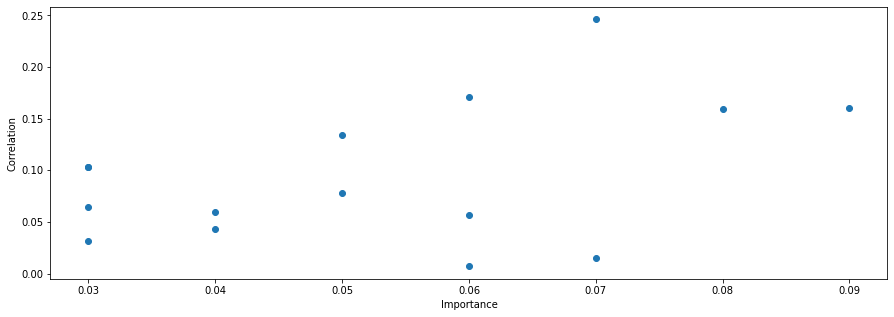

Correlation coefficient:  0.42818513879371384


In [708]:
# Convert correlation to absolute value for the scatterplot
features_small['Correlation'] = features_small['Correlation'].abs()
plt.scatter(features_small['Importance'], features_small['Correlation'])
plt.xlabel('Importance')
plt.ylabel('Correlation')
plt.show()
corr = features_small['Importance'].corr(features_small['Correlation'])

# Display the correlation coefficient
print("Correlation coefficient: ", corr)

Looking at the above code, there seems to be a positive moderate correlation between the variables correlations with Attriition and their feature importance. However, hugh correlation does not necessarily mean high importance in this context.

Now that we selected xgboost and random forest as our models moving forward, let's tune it to achieve the best result possible. Let's start with Random Forest. After running the model, we get an AUC score that is comparable to the scores without hyper parameter tuning. It also takes much longer to run a gridsearch compared to default.

In [739]:
# split the data into training and testing sets, with stratification - to ensure that the distribution is the same for train and test
x_train_0, x_test_0, y_train_0, y_test_0 = train_test_split(x[y==0], y[y==0], test_size=0.5, stratify=y[y==0])
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x[y==1], y[y==1], test_size=0.5, stratify=y[y==1])

    # concatenate the training and testing sets for both classes
x_train = pd.concat([x_train_0, x_train_1], axis=0)
x_test = pd.concat([x_test_0, x_test_1], axis=0)
y_train = pd.concat([y_train_0, y_train_1], axis=0)
y_test = pd.concat([y_test_0, y_test_1], axis=0)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 6],
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator = RandomForestClassifier(), param_grid=param_grid, cv=3, scoring = 'roc_auc')

# Fit the GridSearchCV object to the training data
grid_search.fit(x_train, y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)

# Evaluate the best model on the test data
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(x_test)[:, 1] # assuming your target variable is binary 0 or 1
auc = roc_auc_score(y_test, y_pred_proba)
print('AUC: %.3f' % auc)

Best Parameters:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300}
AUC: 0.787


Now lets look at the AUC chart with our random forest with hyperparameters.

True positive (TP) refers to the cases where the classifier correctly identifies positive instances, while false positive (FP) refers to the cases where the classifier incorrectly identifies negative instances as positive.

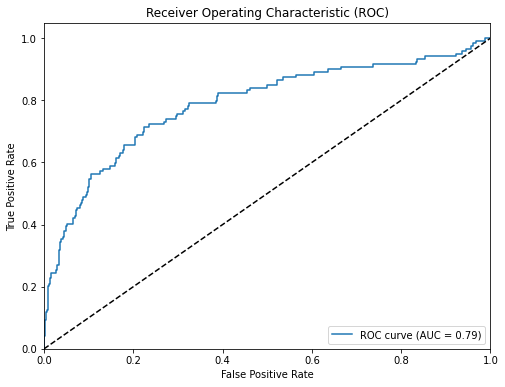

In [745]:
# Calculate the false positive rate, true positive rate, and threshold values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
# Calculate the AUC-ROC score
auc_score = auc(fpr, tpr)
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

The TPR is also known as sensitivity or recall, while the FPR is the complement of specificity.

The diagonal line in the plot represents a random classifier with no predictive power. The ROC curve should ideally be closer to the top-left corner of the plot, indicating higher TPRs and lower FPRs. The AUC score quantifies the overall performance of the classifier, with a higher AUC indicating better discrimination ability.

AUC above random: AUC > 0.5 indicates that the model performs better than random chance.